# CS-471 Machine Learning Assignment # 3  

**Submitted by:** Muhammad Sarmad Saleem  
**Class:** CS 12 A  
**CMS ID:** 411411  

---


# Spectral Clustering Practical Application in Identifying Social Networks Through a Graph-Based Dataset 
---

In [ ]:
!pip install node2vec


# Importing Libraries

In [57]:
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import statistics

## Resuable Functions 

### Loading the Graphs

In [71]:


def load_graph_and_adjacency(file_path):
    """
    Load a graph from an edge list file and return its adjacency matrix.

    Parameters:
    - file_path (str): Path to the edge list file.

    Returns:
    - G (networkx.Graph): The loaded graph.
    - A (numpy.ndarray): The adjacency matrix of the graph.
    - info (dict): Basic information about the graph (number of nodes and edges).
    """
    # Load the graph
    G = nx.read_edgelist(file_path, nodetype=int)

    # Compute the adjacency matrix
    A = nx.to_numpy_array(G)

    return G, A


### Visualizing The Graphs

### Computing Laplacian Matrix

In [60]:
import numpy as np
import networkx as nx

def compute_symmetric_normalized_laplacian(A):
    """
    Compute the symmetric normalized Laplacian matrix L_sym for a given adjacency matrix A.
    
    Parameters:
    - A (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - L_sym (numpy.ndarray): The symmetric normalized Laplacian matrix.
    """
    # Compute the degree matrix D
    D = np.diag(np.sum(A, axis=1))  # Degree matrix D, diagonal with the sum of rows of A

    # Compute D^(-1/2) (Inverse square root of the degree matrix)
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))

    # Compute the symmetric normalized Laplacian: L_sym = I - D^(-1/2) A D^(-1/2)
    L_sym = np.eye(A.shape[0]) - np.dot(D_inv_sqrt, np.dot(A, D_inv_sqrt))

    return L_sym


### Computing Eigen values & Eigen Vectors

In [61]:
import numpy as np

def compute_eigenvalues_and_eigenvectors(matrix):
    """
    Compute the eigenvalues and eigenvectors for a given matrix.

    Parameters:
    - matrix (numpy.ndarray): The matrix for which eigenvalues and eigenvectors are computed.

    Returns:
    - eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
    - eigenvectors (numpy.ndarray): The eigenvectors of the matrix.
    """
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)

    return eigenvalues, eigenvectors


### Chosing Eigen Values

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def compute_eigengap(eigenvalues):
    """
    Compute the eigengap heuristic to estimate the number of clusters k.

    Parameters:
    - eigenvalues (numpy.ndarray): The eigenvalues of the graph's Laplacian.

    Returns:
    - k (int): The estimated number of clusters.
    """
    # Calculate the differences between consecutive eigenvalues (eigengap)
    eigengaps = np.diff(eigenvalues)
    
    # The optimal k is the largest gap
    k = np.argmax(eigengaps) + 1  # +1 because the gap is between consecutive eigenvalues
    
    return k

def plot_eigenvalues(eigenvalues):
    """
    Plot the eigenvalues and show the eigengap.

    Parameters:
    - eigenvalues (numpy.ndarray): The eigenvalues of the Laplacian matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(eigenvalues, marker='o', linestyle='--', color='b')
    plt.title("Eigenvalues of the Laplacian Matrix")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid(True)
    plt.show()

def create_feature_matrix(eigenvectors, k):
    """
    Create a feature matrix U using the first k eigenvectors.

    Parameters:
    - eigenvectors (numpy.ndarray): The eigenvectors of the Laplacian matrix.
    - k (int): The number of clusters (based on eigengap or any other method).

    Returns:
    - U (numpy.ndarray): The feature matrix (first k eigenvectors).
    """
    U = eigenvectors[:, :k]  # Select the first k eigenvectors
    return U

def visualize_feature_matrix(U):
    """
    Visualize the feature matrix U (low-dimensional embedding for clustering).

    Parameters:
    - U (numpy.ndarray): The feature matrix (low-dimensional representation of nodes).
    """
    plt.figure(figsize=(8, 6))
    
    if U.shape[1] == 2:  # 2D plot if U has 2 columns (2D embedding)
        plt.scatter(U[:, 0], U[:, 1], c='blue', marker='o')
        plt.title("2D Visualization of Feature Matrix (Eigenvectors)")
        plt.xlabel("Eigenvector 1")
        plt.ylabel("Eigenvector 2")
    elif U.shape[1] == 3:  # 3D plot if U has 3 columns (3D embedding)
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(U[:, 0], U[:, 1], U[:, 2], c='blue', marker='o')
        ax.set_title("3D Visualization of Feature Matrix (Eigenvectors)")
        ax.set_xlabel("Eigenvector 1")
        ax.set_ylabel("Eigenvector 2")
        ax.set_zlabel("Eigenvector 3")
    else:
        print("Feature matrix has more than 3 dimensions. Visualization may be complex.")

    plt.show()

def spectral_clustering_with_eigengap(L):
    """
    Spectral clustering using the eigengap heuristic to estimate k, and visualization.

    Parameters:
    - L (numpy.ndarray): The Laplacian matrix (e.g., symmetric normalized Laplacian).
    """
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Estimate the number of clusters (k) using eigengap heuristic
    k = compute_eigengap(eigenvalues)

    # Print the estimated number of clusters
    print(f"Estimated number of clusters: {k}")
    
    # Visualize the eigenvalues and eigengap
    plot_eigenvalues(eigenvalues)

    # Create feature matrix U using the first k eigenvectors
    U = create_feature_matrix(eigenvectors, k)

    # Visualize the feature matrix in 2D or 3D
    visualize_feature_matrix(U)

    return k, eigenvalues, eigenvectors, U


### Applying K Means

In [63]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx

def spectral_clustering_kmeans(L, k):
    """
    Perform spectral clustering using k-means on the first k eigenvectors of the Laplacian matrix.

    Parameters:
    - L (numpy.ndarray): The Laplacian matrix (e.g., symmetric normalized Laplacian).
    - k (int): The number of clusters to form.

    Returns:
    - labels (numpy.ndarray): The cluster labels for each node.
    - kmeans (KMeans): The fitted k-means model.
    """
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the first k eigenvectors (corresponding to the k smallest eigenvalues)
    U = eigenvectors[:, :k]

    # Apply k-means clustering to the first k eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(U)

    # Get the cluster labels
    labels = kmeans.labels_

    return labels, kmeans, U

def visualize_clusters(G, labels, k):
    """
    Visualize the graph with node colors corresponding to their cluster labels.

    Parameters:
    - G (networkx.Graph): The graph to visualize.
    - labels (numpy.ndarray): The cluster labels for each node.
    - k (int): The number of clusters.
    """
    # Create a color map based on the cluster labels
    node_colors = [plt.cm.jet(label / k) for label in labels]

    # Plot the graph with node colors based on clusters
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            with_labels=True, 
            node_size=50, 
            font_size=8, 
            font_color='black', 
            node_color=node_colors, 
            edge_color='gray', 
            alpha=0.5)

    plt.title(f"Graph with {k} Clusters from Spectral Clustering")
    plt.show()


### Evaluation Metrics

In [64]:
from sklearn.metrics import silhouette_score

def compute_silhouette_score(X, labels):
    """
    Compute the Silhouette Score for the given clustering.

    Parameters:
    - X (numpy.ndarray): Feature matrix, each row is a data point (node).
    - labels (numpy.ndarray): Cluster labels for each node.

    Returns:
    - silhouette (float): The silhouette score.
    """
    return silhouette_score(X, labels, metric='euclidean')

import networkx as nx

def compute_modularity(G, labels):
    """
    Compute the Modularity of the clustering.

    Parameters:
    - G (networkx.Graph): The graph.
    - labels (numpy.ndarray): Cluster labels for each node.

    Returns:
    - modularity (float): The modularity score.
    """
    return nx.community.modularity(G, [np.where(labels == i)[0] for i in np.unique(labels)])

from sklearn.metrics import normalized_mutual_info_score

def compute_nmi(true_labels, predicted_labels):
    """
    Compute the Normalized Mutual Information (NMI).

    Parameters:
    - true_labels (numpy.ndarray): Ground truth labels.
    - predicted_labels (numpy.ndarray): Predicted cluster labels.

    Returns:
    - nmi (float): The NMI score.
    """
    return normalized_mutual_info_score(true_labels, predicted_labels)
from sklearn.metrics import adjusted_rand_score

def compute_ari(true_labels, predicted_labels):
    """
    Compute the Adjusted Rand Index (ARI).

    Parameters:
    - true_labels (numpy.ndarray): Ground truth labels.
    - predicted_labels (numpy.ndarray): Predicted cluster labels.

    Returns:
    - ari (float): The ARI score.
    """
    return adjusted_rand_score(true_labels, predicted_labels)

import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

def compute_intra_inter_cluster_distances(X, labels):
    """
    Compute the intra-cluster and inter-cluster distances.

    Parameters:
    - X (numpy.ndarray): Feature matrix, each row is a data point (node).
    - labels (numpy.ndarray): Cluster labels for each node.

    Returns:
    - intra_cluster_distance (float): The average intra-cluster distance.
    - inter_cluster_distance (float): The average inter-cluster distance.
    """
    intra_cluster_distances = []
    inter_cluster_distances = []

    # Calculate the intra-cluster distances
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        cluster_center = cluster_points.mean(axis=0)
        intra_cluster_distances.append(np.mean(np.linalg.norm(cluster_points - cluster_center, axis=1)))
    
    intra_cluster_distance = np.mean(intra_cluster_distances)

    # Calculate the inter-cluster distances
    cluster_centers = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    dist_matrix = np.linalg.norm(cluster_centers[:, np.newaxis] - cluster_centers, axis=2)
    np.fill_diagonal(dist_matrix, np.inf)  # Avoid self-comparison
    inter_cluster_distance = np.min(dist_matrix)

    return intra_cluster_distance, inter_cluster_distance


### Combined Function

In [ ]:
def spectral_clustering(file_path):
    # Load the graph and adjacency matrix
    G,A = load_graph_and_adjacency(file_path)

    # Compute the symmetric normalized Laplacian matrix
    L_sym = compute_symmetric_normalized_laplacian(A)

    # Perform spectral clustering using the eigengap heuristic
    k, eigenvalues, eigenvectors, U = spectral_clustering_with_eigengap(L_sym)

    # Perform spectral clustering using k-means
    labels, kmeans, U = spectral_clustering_kmeans(L_sym, k)

    # Visualize the graph with node colors based on clusters
    G = nx.read_edgelist(file_path, nodetype=int)
    visualize_clusters(G, labels, k)

    # Compute the Silhouette Score
    silhouette = compute_silhouette_score(U, labels)
    print(f"Silhouette Score: {silhouette:.4f}")

    # Compute the Modularity
    modularity = compute_modularity(G, labels)
    print(f"Modularity: {modularity:.4f}")

    # Load the ground truth labels
    true_labels = np.loadtxt(file_path,, dtype=int)

    # Compute the Normalized Mutual Information (NMI)
    nmi = compute_nmi(true_labels, labels)
    print(f"NMI: {nmi:.4f}")

    # Compute the Adjusted Rand Index (ARI)
    ari = compute_ari(true_labels, labels)
    print(f"ARI: {ari:.4f}")

    # Compute the intra-cluster and inter-cluster distances
    intra_cluster_distance, inter_cluster_distance = compute_intra_inter_cluster_distances(U, labels)
    print(f"Average Intra-Cluster Distance: {intra_cluster_distance:.4f}")
    print(f"Average Inter-Cluster Distance: {inter_cluster_distance:.4f}")

## Implementation

In [65]:
datasets=["0.edges","348.edges","107.edges","414.edges","686.edges","698.edges","1684.edges","1912.edges","3437.edges","3980.edges"]

### Visualization of each ego

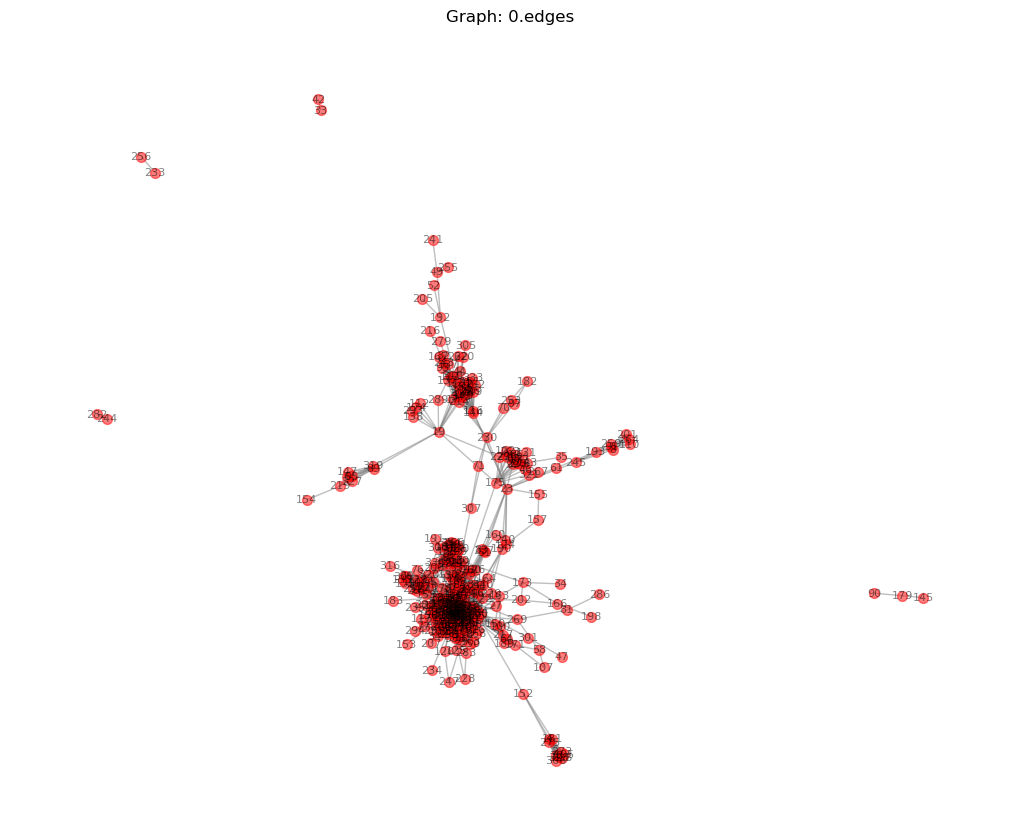

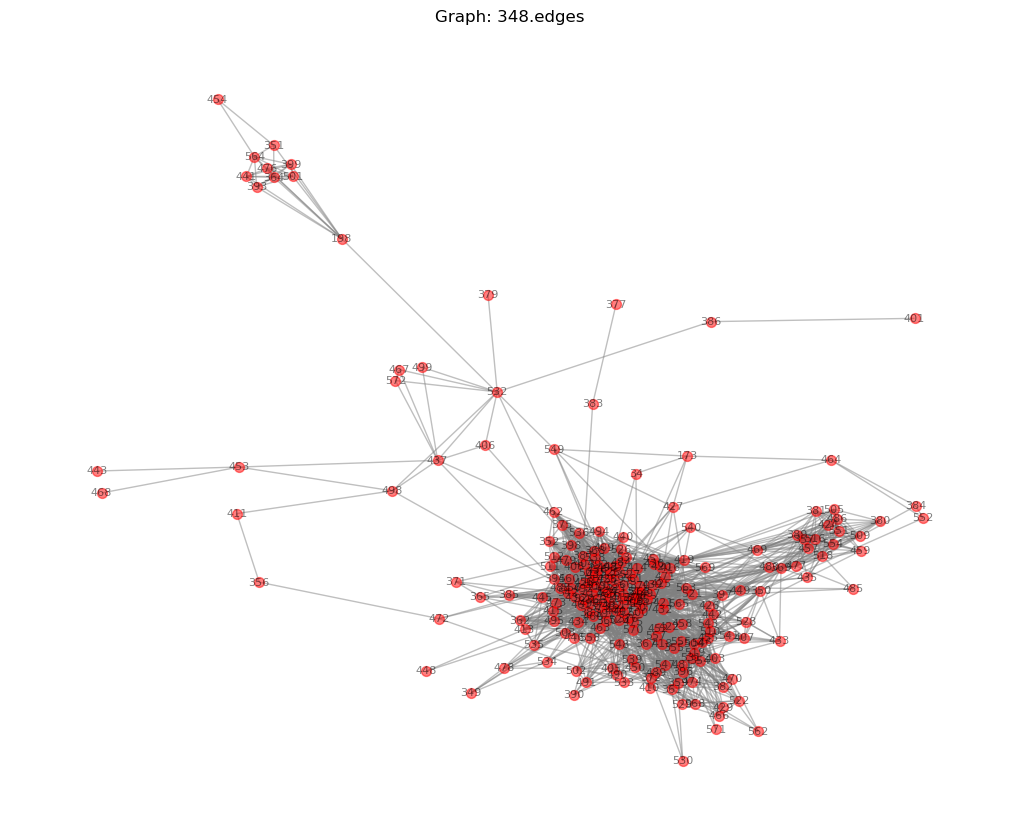

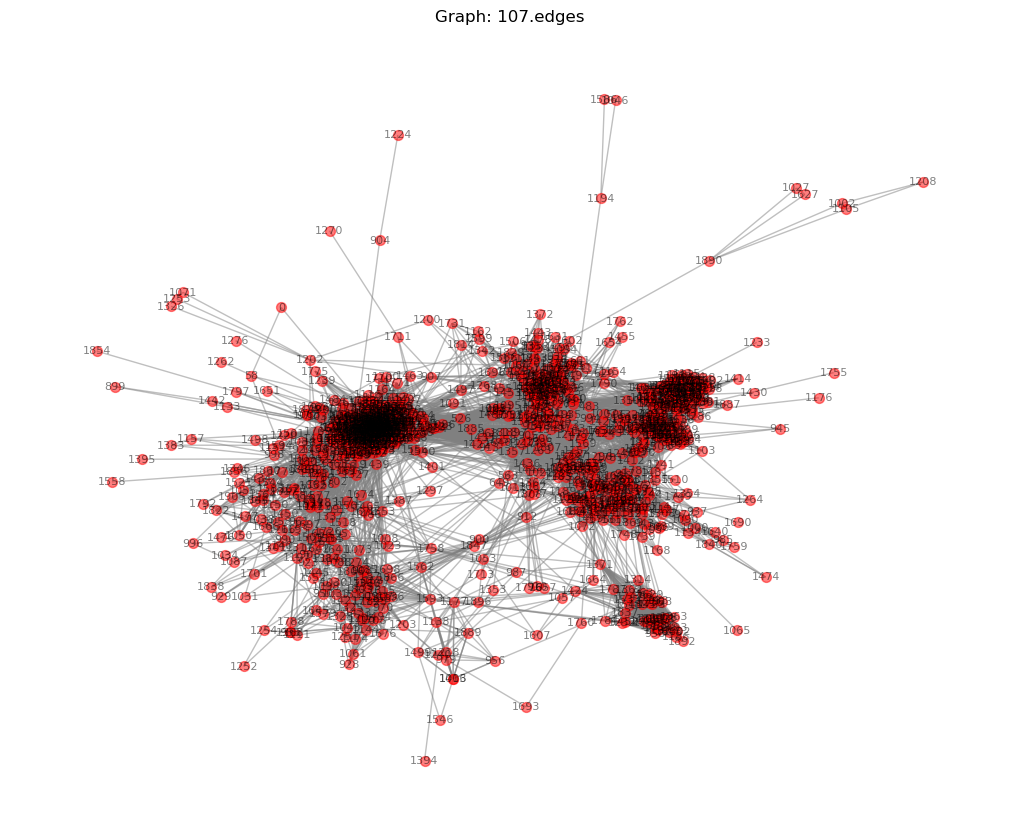

In [ ]:
for dataset in datasets:
   
    G,A=load_graph_and_adjacency("dataset/"+dataset)
    
    visualize_graph(G,title=f"Graph: {dataset}")

### Spectral Clustering Implementation

In [78]:
for dataset in datasets:
    spectral_clustering("dataset/"+dataset)

TypeError: unsupported operand type(s) for /: 'function' and 'str'